In [1]:
# Imports
import glob
import pandas as pd
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load data
conf = OmegaConf.load('../config/features.yaml')
dataset = pd.read_csv('../data/mumu-mc.MGPy8EG_lrsm132_mumuchannel_WRWL_4.50_0.55_0.020_0.000_.EVNT.csv')

In [16]:
# Define transformation onto latent space
def smoothing_function(u: np.ndarray, alpha: float=4, beta: float=3, gamma: float=1) -> np.ndarray:
    
    q = 1 / (1 + np.exp(alpha * (u - beta)) - gamma) * 1 / (1 + np.exp(-alpha * (u + beta)) - gamma)
    
    return q

def get_cumalative_distribution(data: np.ndarray, weights: np.ndarray=None, npoints: int=50, lower_lim: float=None, upper_lim: float=None) -> np.ndarray:
    
    if lower_lim is None:
        lower_lim = np.amin(data)
    if upper_lim is None:
        upper_lim = np.amax(data)
    if weights is None:
        weights = np.ones_like(data, weights, npoints, lower_lim, upper_lim)
    
    ax_scan_points = np.linspace(lower_lim, upper_lim, npoints + 1)
    
    data_cdf = []
    for point in ax_scan_points :
        data_cdf.append(np.sum([w for x,w in zip(data, weights) if x < point]))
        
    data_cdf = np.array(data_cdf)
    
    return data_cdf

def transform_onto_latent_space(data: np.ndarray, conf: OmegaConf, weights: np.ndarray=None):
    
    xmin = np.amin(data)
    xmax = np.amax(data)
    x_scan_points = np.linspace(xmin, xmax, 1 + conf.n_axis_points)

    umin = conf.smooth_space_limits[0]
    umax = conf.smooth_space_limits[1]
    udiv = conf.smooth_space_division
    
    data_cdf = get_cumalative_distribution(data, npoints=conf.n_axis_points, weights=weights)
    constant_cdf = (x_scan_points - xmin) / (xmax - xmin)
    combined_cdf = conf.data_frac_constant * constant_cdf + (1 - conf.data_frac_constant) * data_cdf
    
    latent_space_x = np.linspace(umin, umax, 1 + int(2 * umax / udiv))
    smooth_space_y = smoothing_function(latent_space_x, conf.alpha, conf.beta, conf.gamma)
    
    smooth_space_cdf = np.array([np.sum(smooth_space_y[:i+1]) for i in range(len(smooth_space_y))])
    smooth_space_cdf /= smooth_space_cdf[-1]
    smooth_space_cdf[0] = 0.
    
    constant_cdf    = (latent_space_x + umax) / (2 * umax)
    latent_space_cdf = conf.gauss_frac_constant * constant_cdf + (1 - conf.gauss_frac_constant) * smooth_space_cdf

    A_to_z = lambda A : np.interp(A, x_scan_points, combined_cdf)     # x -> x_CDF
    z_to_A = lambda z : np.interp(z, combined_cdf  , x_scan_points)   # x_CDF -> x

    z_to_g = lambda z : np.interp(z, latent_space_cdf, latent_space_x  )  # u_CDF -> u
    g_to_z = lambda g : np.interp(g, latent_space_x  , latent_space_cdf)  # u -> u_CDF

    A_to_g = lambda A : z_to_g(A_to_z(A))  # x -> u
    g_to_A = lambda g : z_to_A(g_to_z(g))  # u -> x
    
    return A_to_g, g_to_A
    

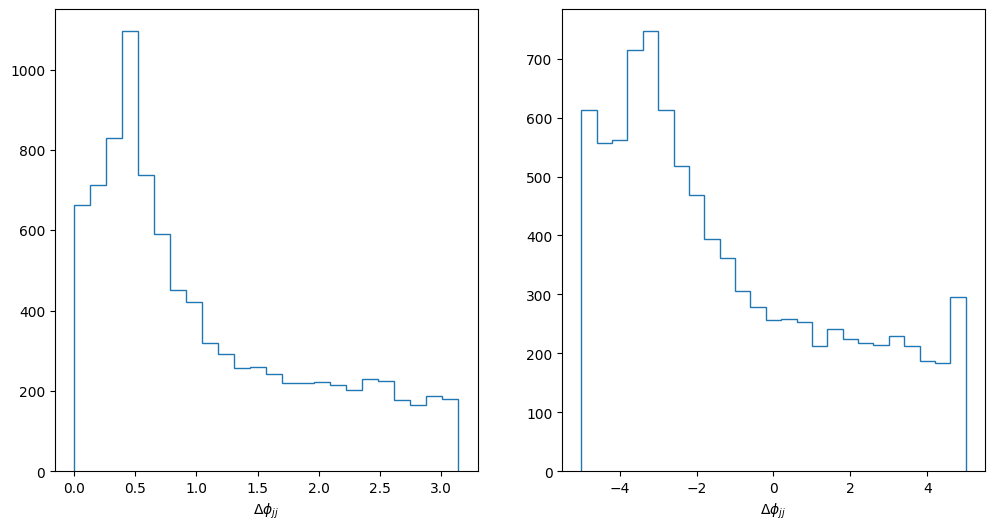

In [17]:
# Plot delta_phi_jj
delta_phi_jj = dataset['delta_phi_jj']
weights = dataset['weight']

x_to_latent_space, latent_space_to_x = transform_onto_latent_space(delta_phi_jj, conf, weights=weights)

delta_phi_jj_trans = x_to_latent_space(delta_phi_jj)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6));
ax1.hist(dataset['delta_phi_jj'], 24, histtype='step', density=False);
ax2.hist(delta_phi_jj_trans, 25, histtype='step', density=False);
ax1.set_xlabel(r"$\Delta\phi_{jj}$");
ax2.set_xlabel(r"$\Delta\phi_{jj}$");

In [19]:
# Check closure

delta_phi_jj_trans_back = latent_space_to_x(delta_phi_jj_trans)

ratio = (delta_phi_jj_trans_back / delta_phi_jj).transpose()
print(f"Observable delta_phi_jj closure is {np.mean(ratio):.5f} +- {np.std(ratio):.5f}     (should be 1 +- 0)")

Observable delta_phi_jj closure is 0.99986 +- 0.00151     (should be 1 +- 0)


In [42]:
# Create GMM 
import tensorflow as tf
from   keras.activations import softplus
from   keras.layers      import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate, Lambda, Reshape, Softmax
from   keras.models      import Model
from   keras.optimizers  import Adam, SGD, Adadelta
from   keras.callbacks   import Callback, EarlyStopping
import keras.backend     as     K

def custom_weight_init_initial (shape, dtype=None, g=0.2) :
    """Keras: custom weight initialiser function for leaky relu layer with gradient g (first layer in network)"""
    limit = 4. / np.sqrt(shape[0]) / (1 + g)
    return K.random_uniform(shape, -limit, limit, dtype=dtype)

def custom_weight_init_hidden (shape, dtype=None, g=0.2) :
    """Keras: custom weight initialiser function for leaky relu layer with gradient g (not first layer in network)"""
    limit = 3. / np.sqrt(shape[0]) / (1 + g)
    return K.random_uniform(shape, -limit, limit, dtype=dtype)

def add_gauss_mean_offsets (x, num_gauss, offset_min, offset_max) :
    """TF method: for input x of size [?, num_gauss], add evenly spaced offsets between [offset_min, offset_max]"""
    c = tf.convert_to_tensor([offset_min + (offset_max-offset_min)*i/(num_gauss-1.) for i in range(num_gauss)])
    return x + c    

def set_initial_gauss_sigmas (x, num_gauss, offset_min, offset_max, gauss_width_factor) :
    """TF method: for input x of size [?, num_gauss], add a constant factor which sets initial Gaussian widths as gauss_width_factor * (offset_max-offset_min) / num_gauss
       - to be applied before a Softmax function, so offset addition is performed in a logarithmic basis"""
    target_width = gauss_width_factor * float(offset_max - offset_min) / num_gauss
    offset       = float(np.log(np.exp(target_width) - 1))
    c = tf.convert_to_tensor([offset for i in range(num_gauss)])
    return x + c

def add_epsilon_to_gauss_sigmas (x, num_gauss, epsilon=1e-4) :
    """TF method: for input x of size [?, num_gauss], add epsilon to every value"""
    c = tf.convert_to_tensor([float(epsilon) for i in range(num_gauss)])
    return x + c

def add_gauss_fraction_offsets (x, num_gauss, const_frac=0.2) :
    """TF method: for input x of size [?, num_gauss], where x is a multinomial(num_gauss) probability distribution, add a constant term to prevent probabilities going to 0"""
    c = tf.convert_to_tensor([1./num_gauss for i in range(num_gauss)])
    return (1.-const_frac)*x + const_frac*c

def K_gauss_prob (x, mean, sigma) :
    """return the Gaussian probability density for datapoints x"""
    prob = K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)
    return prob

def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    """Keras: return the probability density for datapoints x as described by the Gaussian mixture model"""
    prob = 0.
    x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob

def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    """Keras: return the log probability density for datapoints x as described by the Gaussian mixture model"""
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))

def K_dataset_log_likelihood (x, params, num_gauss) :
    """Keras: return the log probability density for datapoints x as described by the Gaussian mixture model"""
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def GMM(conf: OmegaConf) -> tf.keras.Model:
    
    N1     = conf.A1 + conf.A2 * conf.n_external_parameters
    N2     = conf.B1 + conf.B2 * conf.n_observables if conf.n_observables > 0 else 0
    
    conditions_input  = Input((conf.n_external_parameters,))
    model_conditions  = conditions_input
    model_conditions  = Dense(N1, kernel_initializer=custom_weight_init_initial, bias_initializer='zeros', activation='relu')(model_conditions) 
    if conf.use_leaky_relu : model_conditions = LeakyReLU (0.2)      (model_conditions)
    if conf.batch_norm     : model_conditions = BatchNormalization() (model_conditions)
    if conf.dropout > 0.   : model_conditions = Dropout(conf.dropout)     (model_conditions)
    
    #
    #  If they exist, create an input layer for other input observables
    #  -  if configured, add a layer which transforms these inputs onto the given domain
    #  -  add a layer to process just these inputs
    #  -  concatenate the resulting hidden layer with that from the external parameter dependence
    #  If they don't exist, skip this step
    #
    
    if conf.n_observables > 0 :
        observables_input = Input((conf.n_observables,))
        model_observables = observables_input
        model_observables = Dense(N2, kernel_initializer=custom_weight_init_initial, bias_initializer='zeros', activation='relu')(model_observables)    
        if conf.use_leaky_relu : model_observables = LeakyReLU(0.2)       (model_observables)
        if conf.batch_norm     : model_observables = BatchNormalization() (model_observables)
        if conf.dropout > 0.   : model_observables = Dropout(conf.dropout)     (model_observables)
        model             = Concatenate()([model_conditions, model_observables])
    else :
        model = model_conditions
        
    for c in range(conf.C) :
        model = Dense (N1 + N2, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
        if conf.use_leaky_relu : model = LeakyReLU (0.2)      (model)
        if conf.batch_norm     : model = BatchNormalization() (model)
        if conf.dropout > 0.   : model = Dropout(conf.dropout)     (model)
    
    gauss_means     = Dense (conf.D2 * conf.num_gaussians, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
    if conf.use_leaky_relu : gauss_means = LeakyReLU (0.2)      (gauss_means)
    if conf.batch_norm     : gauss_means = BatchNormalization() (gauss_means)
    if conf.dropout > 0.   : gauss_means = Dropout(conf.dropout)     (gauss_means)
    gauss_means = Dense (conf.num_gaussians, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation="linear")(gauss_means)
    gauss_means = Lambda(lambda x : conf.gauss_mean_scale * x)(gauss_means)
    gauss_means = Lambda(lambda x : add_gauss_mean_offsets(x, conf.num_gaussians, conf.range_min, conf.range_max))(gauss_means)
    
    gauss_sigmas       = Dense (conf.D2 * conf.num_gaussians   , kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
    if conf.use_leaky_relu : gauss_sigmas = LeakyReLU (0.2)      (gauss_sigmas)
    if conf.batch_norm     : gauss_sigmas = BatchNormalization() (gauss_sigmas)
    if conf.dropout > 0.   : gauss_sigmas = Dropout(conf.dropout)     (gauss_sigmas)
    gauss_sigmas = Dense (conf.num_gaussians     , kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : conf.gauss_sigma_scale * x )                                                                (gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : set_initial_gauss_sigmas(x, conf.num_gaussians, conf.range_min, conf.range_max, conf.gauss_width_factor))(gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : K.log(1. + K.exp(x)))                                                                (gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : add_epsilon_to_gauss_sigmas(x, conf.num_gaussians))                                       (gauss_sigmas)
    
    
    gauss_fractions = Dense(conf.D2 * conf.num_gaussians , kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
    if conf.use_leaky_relu : gauss_fractions = LeakyReLU (0.2)      (gauss_fractions)
    if conf.batch_norm     : gauss_fractions = BatchNormalization() (gauss_fractions)
    if conf.dropout > 0.   : gauss_fractions = Dropout(conf.dropout)     (gauss_fractions)
    gauss_fractions = Dense(conf.num_gaussians, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation="linear")(gauss_fractions)
    gauss_fractions = Lambda(lambda x : conf.gauss_frac_scale * x)                                                    (gauss_fractions)
    gauss_fractions = Softmax()                                                                                (gauss_fractions)
    gauss_fractions = Lambda(lambda x : add_gauss_fraction_offsets(x, conf.num_gaussians, conf.min_gauss_amplitude_frac))(gauss_fractions)
    
    
    model = Concatenate()([gauss_fractions, gauss_means, gauss_sigmas])
    if conf.n_observables > 0 : model = Model ([conditions_input, observables_input], model, name='GMM')
    else                      : model = Model (conditions_input, model, name='GMM')
    
    loss_function = lambda y_true, y_pred : -1. * K_dataset_log_likelihood(y_true, y_pred, conf.num_gaussians)
    #loss_function = lambda y_true, y_pred : K_dataset_PlogP (y_true, y_pred, num_gaussians)
    if   conf.optimiser.lower() == "sgd"      : model.compile(loss=loss_function, optimizer=SGD     (learning_rate=conf.learning_rate))    
    elif conf.optimiser.lower() == "adadelta" : model.compile(loss=loss_function, optimizer=Adadelta(learning_rate=conf.learning_rate))    
    elif conf.optimiser.lower() == "adam"     : model.compile(loss=loss_function, optimizer=Adam    (learning_rate=conf.learning_rate))   
    else : raise ValueError(f"Optimiser '{conf.optimiser}' not recognised") 
    
    return model, (conf.n_external_parameters, conf.n_observables, conf.num_gaussians)

In [47]:
# Train model
from sklearn.model_selection import train_test_split

model_conf = OmegaConf.load('../config/features/delta_phi_jj.yaml')

model, params = GMM(model_conf)

y = dataset['delta_phi_jj']
weights = dataset['weight']

x = np.stack([4.5, 0.55, 0.02, 0.0] for _ in range(len(y)));

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42);

history = model.fit(x, y, sample_weight=weights, validation_split=0.1, epochs=30, shuffle=True, batch_size=4);



Epoch 1/30
2052/2052 [==============================] - 102s 45ms/step - loss: 2.9744e-04 - val_loss: nan
Epoch 2/30
2052/2052 [==============================] - 94s 46ms/step - loss: 2.5117e-04 - val_loss: 0.0010
Epoch 3/30
2052/2052 [==============================] - 93s 45ms/step - loss: 1.6836e-04 - val_loss: 5.9017e-04
Epoch 4/30
2052/2052 [==============================] - 89s 43ms/step - loss: 1.5403e-04 - val_loss: 3.1315e-04
Epoch 5/30
2052/2052 [==============================] - 88s 43ms/step - loss: 1.4312e-04 - val_loss: 4.6483e-04
Epoch 6/30
2052/2052 [==============================] - 95s 46ms/step - loss: 1.3725e-04 - val_loss: 3.0987e-04
Epoch 7/30
2052/2052 [==============================] - 94s 46ms/step - loss: 1.3329e-04 - val_loss: 1.9472e-04
Epoch 8/30
 180/2052 [=>............................] - ETA: 1:28 - loss: 1.3292e-04

In [ ]:
# Plot loss vs epochs
fig, ax = plt.subplots()
ax.plot(history['loss'], label='Train')
ax.plot(history['val_loss'], label='Val')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()